# Alanyze data using behavioral model
There are 3 models with different parameter combinations:

1. <b>The Bayesian model (Schwöbel et al. 2021):</b> \
   <b>a.</b> With 3 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, and a decision temparature $\beta$. \
   <b>b.</b> With 4 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, a decision temparature $\beta$, and a habitual tendency $h$.
2. <b>A newer MF/MB version that is better for fitting (Otto et al. 2013):</b> \
<b>Note:</b> This is not quite the original version, as the Q-values in the original work did not converge to the true expected values. Instead, I implemented a "bug-fixed" version.\
   <b>a.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$$, and a repetition/perserveration parameter $p$. \
3. <b>The original model-free/model-based (MF/MB) model (Daw et al. 2005, 2011):</b> \
   <b>a.</b> With 4 parameters: a weighting parameters $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a weighting parameter $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, a dicount factor $\lambda$, and a repetition/perserveration parameter $p$.

Tell python that the code in the submodule is code that we want to import and run

In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf

torch threads 1
Running on device cpu


Other imports that we need for simulation, inference, and plotting

In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import jsonpickle as pickle
import json
import gc
# import pickle

Define where results should be saved

In [3]:
results_folder = "results"
simulation_folder = os.path.join(results_folder, "simulations")
recovery_folder = os.path.join(results_folder, "recovery")

inference_folder = os.path.join(results_folder, "inference")

Where pre-processed info is found

In [4]:
results_folder = os.path.join("results")
processed_data_folder = os.path.join("processed_data")

mask_file_name = "mask.pkl"
mask_file = os.path.join(processed_data_folder, mask_file_name)

Rho_fname = "Rho.pkl"
Rho_file = os.path.join(processed_data_folder, Rho_fname)

agent_data_fname = "data_formatted_for_agent.pkl"
agent_data_file = os.path.join(processed_data_folder, agent_data_fname)

In [5]:
def convert_data_for_agent(data):

    data_obs = torch.stack([torch.from_numpy(d["observations"]) for d in data], dim=-1)
    data_rew = torch.stack([torch.from_numpy(d["rewards"]) for d in data], dim=-1)
    data_act = torch.stack([torch.from_numpy(d["actions"]) for d in data], dim=-1)
    data_val = torch.cat([torch.from_numpy(d["valid"]) for d in data], dim=-1)
    data_ind = torch.stack([torch.from_numpy(d["subject"]) for d in data], dim=-1)

    structured_data = {"subject": data_ind, "observations": data_obs, "rewards": data_rew, "actions": data_act, "valid": data_val}

    return structured_data

In [6]:
with open(agent_data_file, 'r') as infile:
    loaded = json.load(infile)
full_data = pickle.decode(loaded)

n_agents = len(full_data)
print("n subjects", n_agents)

data = convert_data_for_agent(full_data)

print(data)

n subjects 24
{'subject': tensor([[ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23],
        ...,
        [ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23]]), 'observations': tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 2,  1,  1,  ...,  1,  1,  1],
         [ 4,  3,  3,  ...,  3,  3,  3]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  1,  ...,  1,  1,  2],
         [ 3,  3,  3,  ...,  3,  3,  4]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 2,  1,  1,  ...,  1,  1,  1],
         [ 4,  5,  3,  ...,  3,  3,  3]],

        ...,

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  

In [7]:
#print(full_data["observations"][:10,:,50])

#print(full_data["actions"][:10,:,50])

#print(full_data["rewards"][:10,:,50])

#### Global experiment parameters

In [8]:
# number of simulated agents/participants
#n_agents = int(full_data_df['subject'].max()+1)
#n_agents = 15
#print(n_agents)

#start_ind = 30
#end_ind = start_ind + n_agents

#data_small = {"observations": full_data["observations"][...,start_ind:end_ind], "rewards": full_data["rewards"][...,start_ind:end_ind], "actions": full_data["actions"][...,start_ind:end_ind], "valid": full_data["valid"][...,start_ind:end_ind]}

#data = data_small

#print(data["rewards"].shape)torch.from_numpy(

In [9]:
trials =  272#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
p_valid = 0.01

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid}

Define states and transition matrices

In [10]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

Load and plot reward probabilities

In [11]:
with open(Rho_file, 'r') as infile:
    loaded = json.load(infile)
Rho = pickle.decode(loaded)

# add to parameter dict
global_experiment_parameters["Rho"] = torch.from_numpy(Rho)

Now we can start :) 

### 1. BCC:
### 1.a 3 parameter version

Simulation pre-setup

In [12]:
# set parameters and their names

infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

# choose max decision temperature for numerical stability
max_dt = 6

#### Inference

Inference pre-setup

In [13]:
# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 600

BCC_3param_inference_


<b>Decide</b> for running or loading inference

In [14]:
run_inference = True

<b>Either:</b> Set up agent and inference. Run main inference loop, plot intermediate and end results

/home/sarah/src/BayesianTwoStageTaskAnalysis/FeherDaSilva_magic_carpet_data/../code/BalancingControl/perception.py:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


analyzing 24 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 100 out of total 600


Mean ELBO 5878.80: 100%|██████████| 100/100 [08:34<00:00,  5.14s/it]


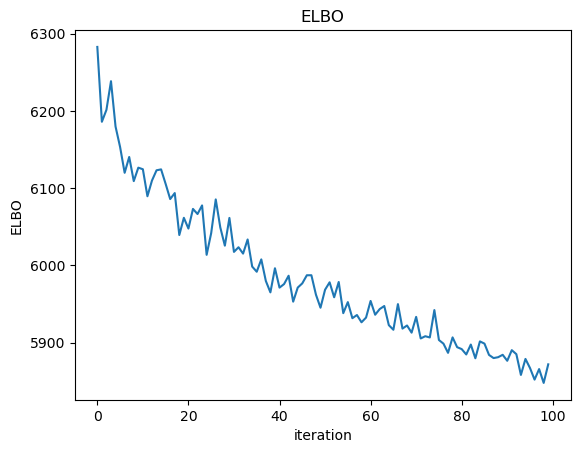

<Figure size 640x480 with 0 Axes>

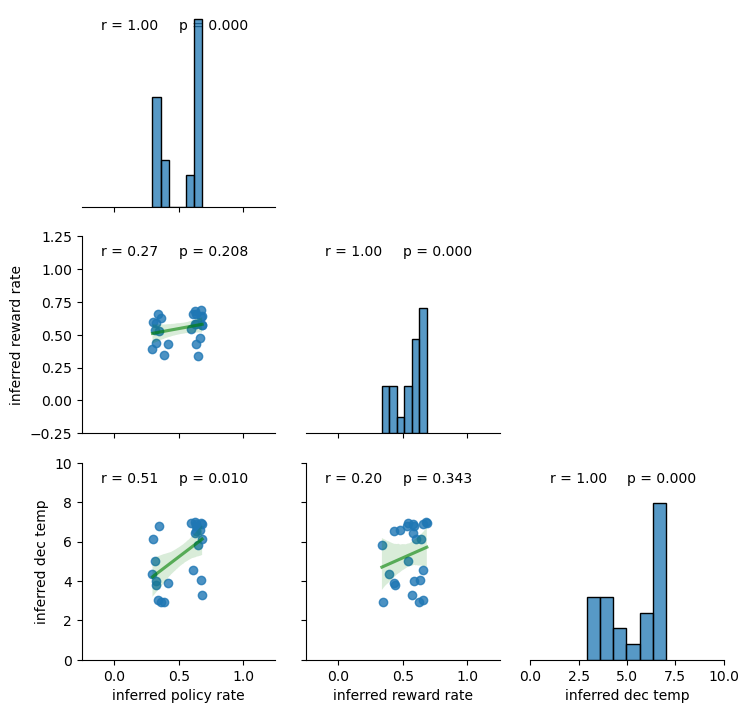

taking steps 101 to 200 out of total 600


Mean ELBO 5770.87: 100%|██████████| 100/100 [09:13<00:00,  5.53s/it]


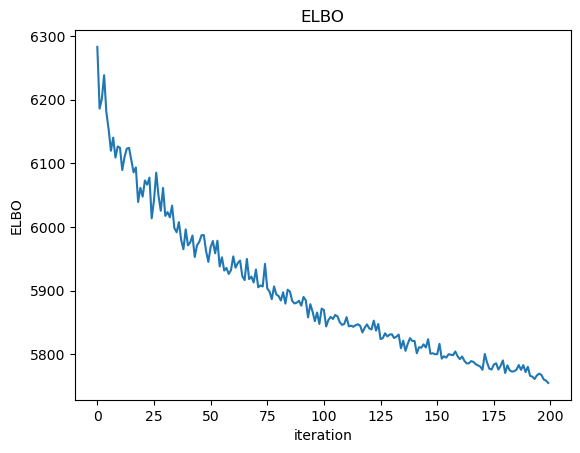

<Figure size 640x480 with 0 Axes>

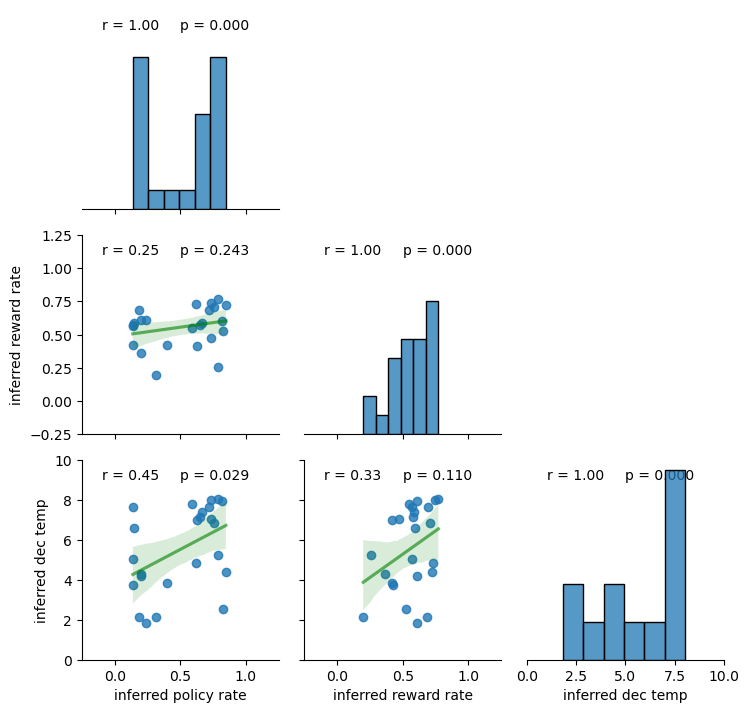

taking steps 201 to 300 out of total 600


Mean ELBO 5719.75: 100%|██████████| 100/100 [13:04<00:00,  7.85s/it]


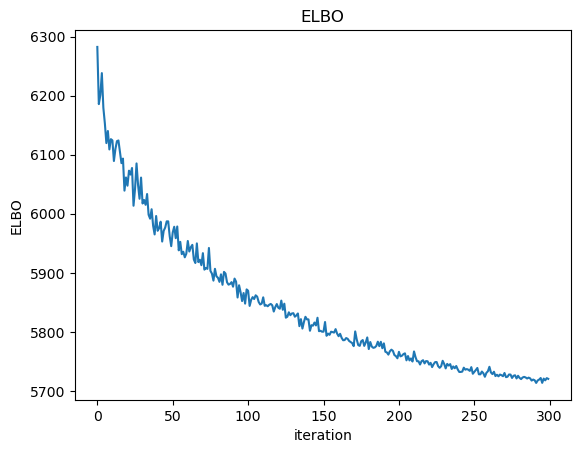

<Figure size 640x480 with 0 Axes>

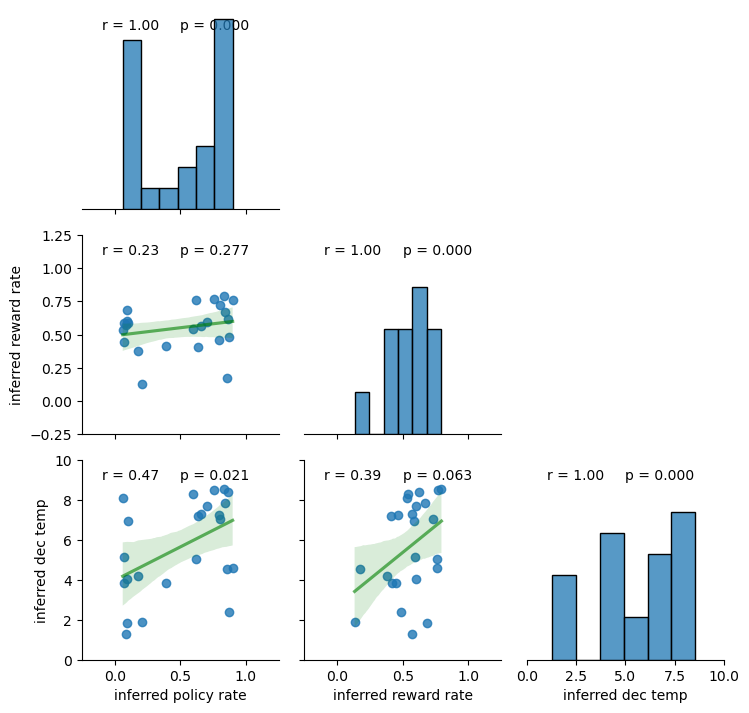

taking steps 301 to 400 out of total 600


Mean ELBO 5701.15: 100%|██████████| 100/100 [12:08<00:00,  7.29s/it]


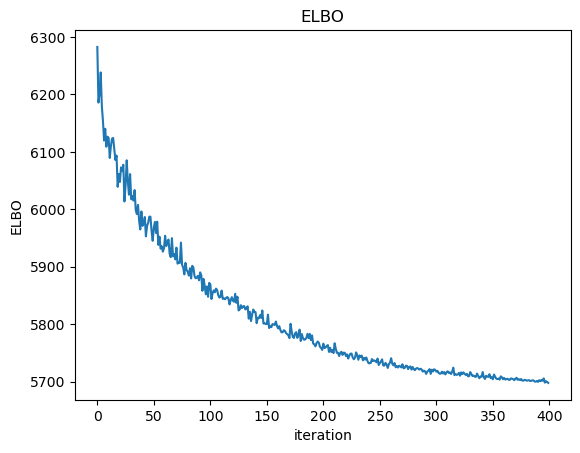

<Figure size 640x480 with 0 Axes>

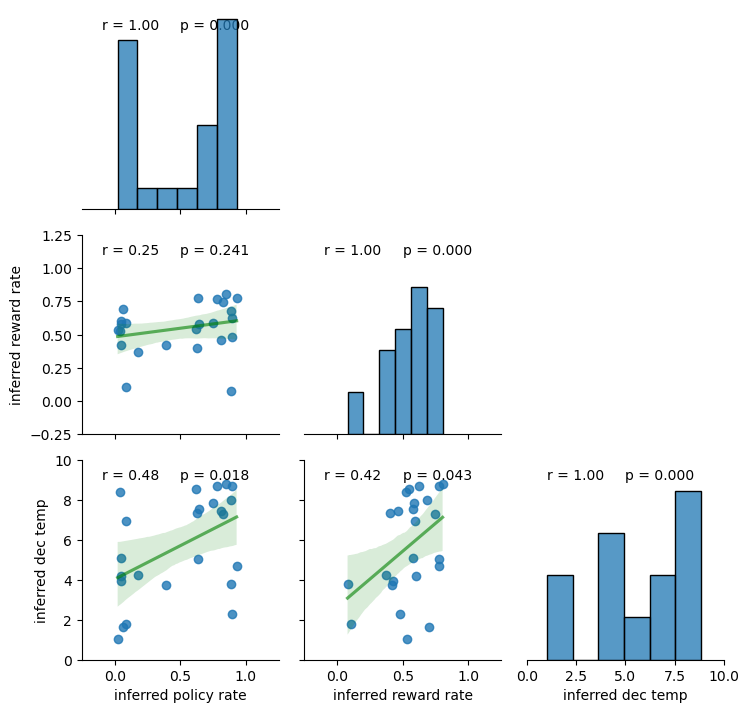

taking steps 401 to 500 out of total 600


Mean ELBO 5691.41: 100%|██████████| 100/100 [11:47<00:00,  7.07s/it]


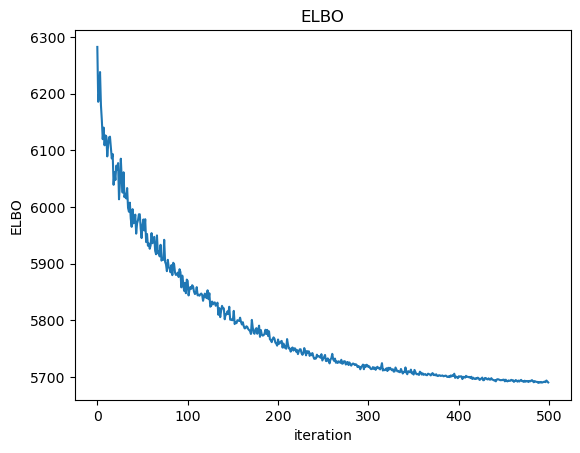

<Figure size 640x480 with 0 Axes>

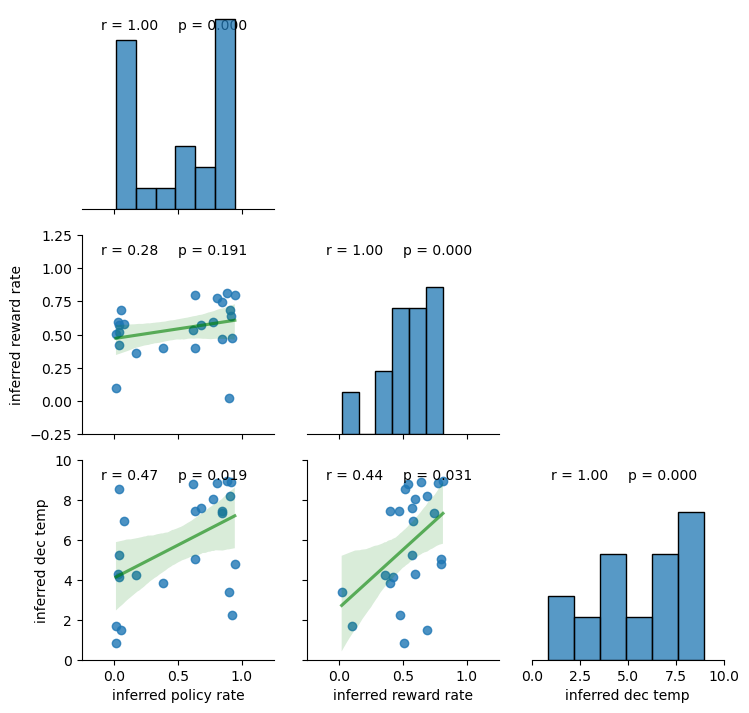

taking steps 501 to 600 out of total 600


Mean ELBO 5687.61: 100%|██████████| 100/100 [11:37<00:00,  6.97s/it]


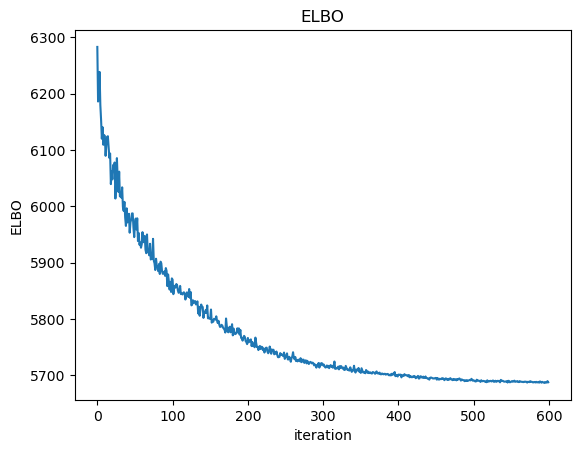

<Figure size 640x480 with 0 Axes>

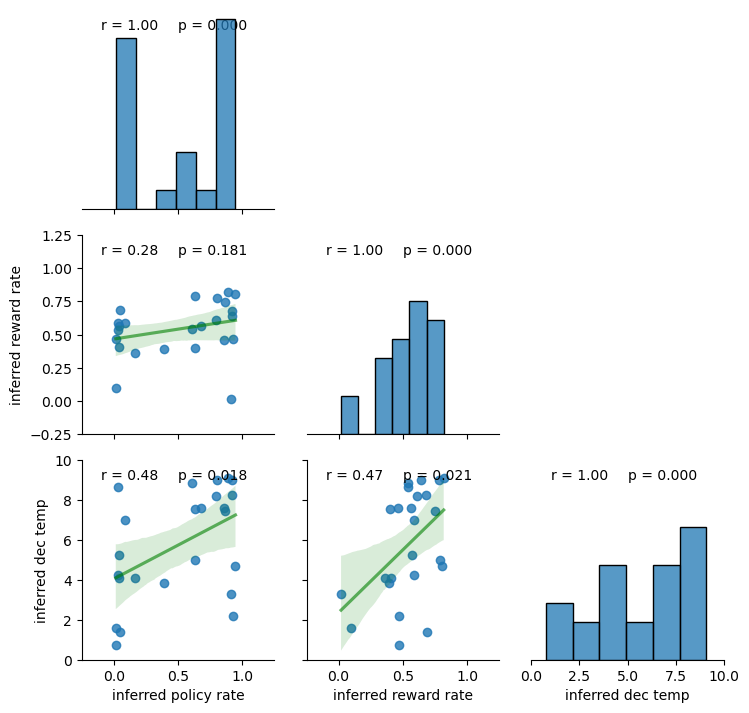

In [15]:
if run_inference:

    # remove old inference?
    remove_old = False

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old)

    print('analyzing '+str(n_agents)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 100
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_agents)+'agents'

        tu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 

        param_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

        plt.figure()
        vars_of_interest = ["inferred "+name for name in param_names]
        f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,# hue="subject",
                            plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                            grid_kws={"layout_pad": 1.5},
                            x_vars=vars_of_interest, y_vars=vars_of_interest)
        f.map(tu.annot_corrfunc)
        for p, p_range in enumerate(param_ranges):
            f.axes[2,p].set_xlim(p_range)
            f.axes[p,0].set_ylim(p_range)
        plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
        plt.show()

    # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
    mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 

<b>Or:</b> Set up agent and inference. Load past inference, decide whether to resample posterior or used stored samples

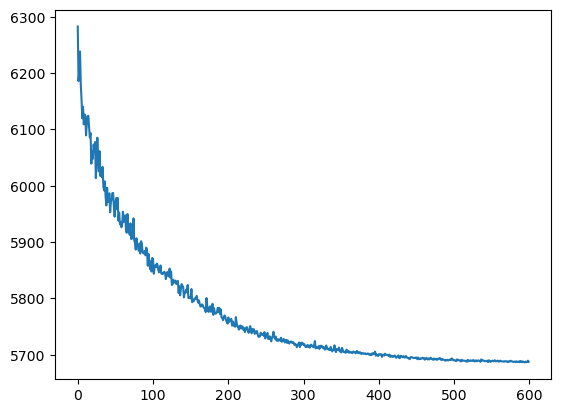

last ELBO: tensor(5687.5171)


In [16]:
if not run_inference:

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = True

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

plt.figure()
plt.plot(inferrer.loss)
plt.show()

print("last ELBO:", inferrer.loss[-1])

<Figure size 640x480 with 0 Axes>

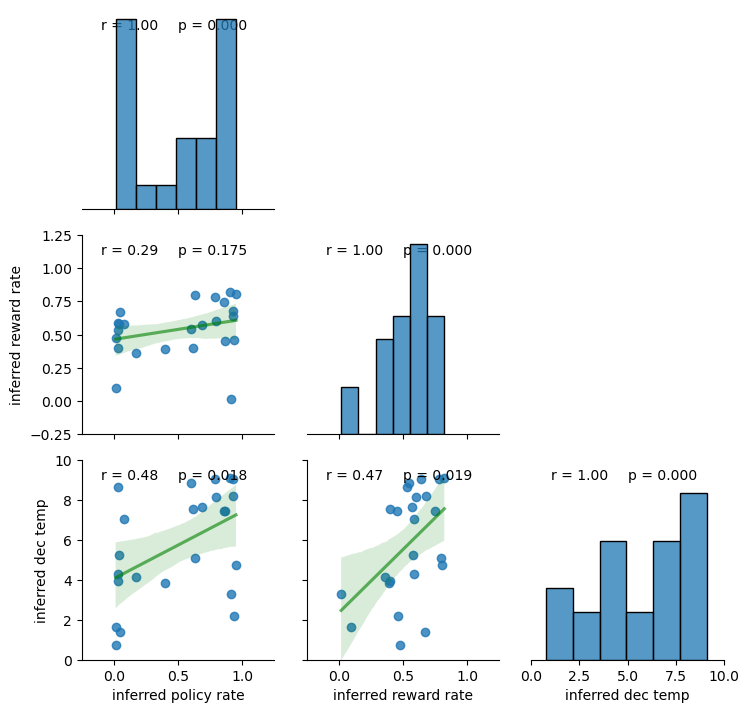

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_3param) with 24 agents.
The settings are: infer h False


In [17]:
param_ranges = [[0,1], [0,1], [0,max_dt]]

param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    grid_kws={"layout_pad": 1.5},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)